<a href="https://colab.research.google.com/github/jpupkies/Jim-Pupkies/blob/master/Gemini_Legal_Document_Conflict_Resolver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gemini_Legal_Document_Conflict_Resolver

## Purpose

This notebook demonstrates how an LLM-powered system can **analyze conflicting or ambiguous legal documents** and provide structured decision support.

Unlike traditional notebooks that focus only on content extraction or summarization, this notebook emphasizes **ambiguity handling, conflict detection, and human-in-the-loop escalation** — critical skills for enterprise legal, compliance, or regulatory workflows.

## Domain Focus

**Legal Document Analysis / Compliance**

- Documents may **contradict each other** on key terms or obligations.
- Some documents may be **incomplete or partial**, leaving gaps in interpretation.
- Human review is often required when LLM confidence is low or conflicts are high.

## Key Concepts

- **Conflict Scoring:** Quantify disagreement between multiple documents on the same topic.  
- **Confidence Collapse:** Detect when LLM outputs are inconsistent or unreliable.  
- **Abstention & Deferral:** Avoid automatic decisions under high ambiguity.  
- **Human-in-the-Loop Signaling:** Escalate high-risk cases for expert review.

## Notebook Flow

1. Input Modeling — Capture multiple, potentially conflicting legal documents.  
2. LLM Analysis — Interpret each document independently.  
3. Conflict & Consistency Scoring — Measure disagreement between documents.  
4. Confidence Collapse Detection — Identify unstable or low-confidence interpretations.  
5. Abstention & Deferral Logic — Determine appropriate actions.  
6. Human-in-the-Loop Signaling — Route ambiguous cases to legal experts.  
7. Reporting & Visualization — Generate structured summaries and visualizations.  
8. Summary & Engineering Takeaways — Consolidate insights and best practices.

This notebook emphasizes **responsible AI in legal workflows**, making uncertainty, conflicts, and human oversight explicit.

## Step 1 — Input Modeling: Conflicting Legal Documents

The system receives multiple legal documents that describe the same agreement, clause, or obligation.  

Each document may:  
- Contain conflicting language or interpretations  
- Be incomplete or partially redacted  
- Vary in credibility or source authority  

At this stage, no attempt is made to resolve conflicts.  
The goal is to model inputs **exactly as they arrive**, preserving ambiguity for downstream analysis.

In [1]:
from dataclasses import dataclass
from typing import Optional, List

@dataclass
class LegalDocument:
    source: str
    text: str
    section: Optional[str]
    confidence: Optional[float]  # optional human-assigned or heuristic confidence

# Example conflicting documents
documents: List[LegalDocument] = [
    LegalDocument(
        source="Legal Team A",
        text="Clause 5 states that the vendor is liable for all damages arising from product defects.",
        section="Clause 5",
        confidence=0.8
    ),
    LegalDocument(
        source="Legal Team B",
        text="Clause 5 limits vendor liability to direct damages only, excluding indirect or consequential losses.",
        section="Clause 5",
        confidence=0.7
    ),
    LegalDocument(
        source="External Counsel",
        text="Clause 5 does not explicitly define the scope of liability for indirect damages.",
        section="Clause 5",
        confidence=0.9
    ),
    LegalDocument(
        source="Internal Compliance",
        text="Clause 5 mentions liability but is redacted in key areas regarding indirect damages.",
        section="Clause 5",
        confidence=0.6
    ),
]

documents

[LegalDocument(source='Legal Team A', text='Clause 5 states that the vendor is liable for all damages arising from product defects.', section='Clause 5', confidence=0.8),
 LegalDocument(source='Legal Team B', text='Clause 5 limits vendor liability to direct damages only, excluding indirect or consequential losses.', section='Clause 5', confidence=0.7),
 LegalDocument(source='External Counsel', text='Clause 5 does not explicitly define the scope of liability for indirect damages.', section='Clause 5', confidence=0.9),
 LegalDocument(source='Internal Compliance', text='Clause 5 mentions liability but is redacted in key areas regarding indirect damages.', section='Clause 5', confidence=0.6)]

- Establishes a set of **conflicting legal documents** for the same section.  
- Preserves disagreements and partial information instead of normalizing or resolving it.  
- Explicitly models **source, text, section, and confidence** for downstream analysis.  

At the end of this step, the system has **structured input** ready for independent LLM analysis, while retaining all ambiguity and conflict.

## Step 2 — LLM Analysis of Each Document

Each legal document will now be analyzed independently by the LLM.  

Goals:  
- Generate structured interpretations of each document  
- Infer potential obligations, liabilities, or risks  
- Produce an internal confidence estimate per document  

No cross-document comparison or aggregation is performed yet; this step focuses on **document-level model uncertainty**.

In [2]:
# Placeholder function simulating LLM interpretation of a legal document
def analyze_legal_document_with_llm(doc: LegalDocument):
    """
    Returns a dictionary with:
    - inferred_liability: model's interpretation of vendor liability
    - risk_estimate: numeric estimate of potential legal risk
    - model_confidence: LLM's self-reported confidence
    """
    # Simplified heuristic logic for demonstration
    if "direct damages only" in doc.text:
        inferred_liability = "Limited Liability"
        risk_estimate = 2
    elif "all damages" in doc.text:
        inferred_liability = "Full Liability"
        risk_estimate = 5
    else:
        inferred_liability = "Unclear"
        risk_estimate = 3

    model_confidence = doc.confidence or 0.5
    return {
        "source": doc.source,
        "section": doc.section,
        "inferred_liability": inferred_liability,
        "risk_estimate": risk_estimate,
        "model_confidence": model_confidence
    }

# Apply analysis to all documents
llm_document_analysis = [analyze_legal_document_with_llm(d) for d in documents]
llm_document_analysis

[{'source': 'Legal Team A',
  'section': 'Clause 5',
  'inferred_liability': 'Full Liability',
  'risk_estimate': 5,
  'model_confidence': 0.8},
 {'source': 'Legal Team B',
  'section': 'Clause 5',
  'inferred_liability': 'Limited Liability',
  'risk_estimate': 2,
  'model_confidence': 0.7},
 {'source': 'External Counsel',
  'section': 'Clause 5',
  'inferred_liability': 'Unclear',
  'risk_estimate': 3,
  'model_confidence': 0.9},
 {'source': 'Internal Compliance',
  'section': 'Clause 5',
  'inferred_liability': 'Unclear',
  'risk_estimate': 3,
  'model_confidence': 0.6}]

- Analyzes each document **independently** using the LLM  
- Produces an inferred liability classification and risk estimate for each document  
- Generates a per-document model confidence value  
- Does **not** attempt to reconcile conflicts or aggregate results  

At the end of this step, the system has a structured LLM interpretation for each document, ready for conflict scoring and uncertainty analysis.

## Step 3 — Conflict & Consistency Scoring

Now that each legal document has been independently analyzed by the LLM, the system evaluates **how the documents agree or conflict**.  

Goals:  
- Quantify disagreement between interpretations of the same section  
- Identify areas where inferred liabilities or risk estimates diverge  
- Prepare for confidence collapse detection and abstention logic

In [3]:
# Simple function to compute pairwise conflict scores between documents
def compute_document_conflict_score(doc_a, doc_b):
    """
    Returns a numeric score representing conflict:
    - 0: no conflict
    - Higher values: more conflict
    """
    liability_conflict = 0 if doc_a['inferred_liability'] == doc_b['inferred_liability'] else 1
    confidence_diff = abs(doc_a['model_confidence'] - doc_b['model_confidence'])
    return liability_conflict + confidence_diff

# Compute pairwise conflict scores
document_conflict_matrix = []
for i, doc_a in enumerate(llm_document_analysis):
    row = []
    for j, doc_b in enumerate(llm_document_analysis):
        if i == j:
            row.append(0.0)
        else:
            row.append(compute_document_conflict_score(doc_a, doc_b))
    document_conflict_matrix.append(row)

document_conflict_matrix

[[0.0, 1.1, 1.1, 1.2000000000000002],
 [1.1, 0.0, 1.2000000000000002, 1.1],
 [1.1, 1.2000000000000002, 0.0, 0.30000000000000004],
 [1.2000000000000002, 1.1, 0.30000000000000004, 0.0]]

- Calculates pairwise conflict scores between all legal documents  
- Highlights where inferred liabilities or model confidences diverge  
- Produces a **conflict matrix** representing agreement and disagreement between documents  
- Lays the foundation for detecting confidence collapse and deciding when to defer or escalate to human review  

At the end of this step, the system can **measure ambiguity explicitly** between documents.

## Step 4 — Confidence Collapse Detection

After computing conflict scores, the system now evaluates whether the LLM's interpretations are **unstable or inconsistent across documents**.  

Goals:  
- Detect situations where no clear consensus emerges  
- Identify when confidence values are too low or too divergent to support an automatic decision  
- Provide early warning that abstention or deferral may be required

In [4]:
import numpy as np

# Calculate average conflict per document
avg_conflict_per_document = np.mean(document_conflict_matrix, axis=1)

# Define a threshold for confidence collapse
CONFIDENCE_COLLAPSE_THRESHOLD = 0.7

# Detect documents experiencing confidence collapse
confidence_collapse_flags = [
    avg_conflict > CONFIDENCE_COLLAPSE_THRESHOLD for avg_conflict in avg_conflict_per_document
]

# Combine results with LLM analysis for reporting
confidence_collapse_results = [
    {**llm_document_analysis[i], "avg_conflict": avg_conflict_per_document[i], "confidence_collapse": flag}
    for i, flag in enumerate(confidence_collapse_flags)
]

confidence_collapse_results

[{'source': 'Legal Team A',
  'section': 'Clause 5',
  'inferred_liability': 'Full Liability',
  'risk_estimate': 5,
  'model_confidence': 0.8,
  'avg_conflict': np.float64(0.8500000000000001),
  'confidence_collapse': np.True_},
 {'source': 'Legal Team B',
  'section': 'Clause 5',
  'inferred_liability': 'Limited Liability',
  'risk_estimate': 2,
  'model_confidence': 0.7,
  'avg_conflict': np.float64(0.8500000000000001),
  'confidence_collapse': np.True_},
 {'source': 'External Counsel',
  'section': 'Clause 5',
  'inferred_liability': 'Unclear',
  'risk_estimate': 3,
  'model_confidence': 0.9,
  'avg_conflict': np.float64(0.6500000000000001),
  'confidence_collapse': np.False_},
 {'source': 'Internal Compliance',
  'section': 'Clause 5',
  'inferred_liability': 'Unclear',
  'risk_estimate': 3,
  'model_confidence': 0.6,
  'avg_conflict': np.float64(0.6500000000000001),
  'confidence_collapse': np.False_}]

- Measures average conflict per document to detect instability  
- Flags documents where conflict exceeds a threshold as **confidence collapse**  
- Prepares the system to make principled abstention or deferral decisions  
- Makes ambiguity **quantitative and actionable**  

At the end of this step, the system can identify which documents are too uncertain to act on automatically.

## Step 5 — Abstention & Deferral Logic

Using the conflict and confidence collapse analysis, the system now decides **how to respond to ambiguous or conflicting legal documents**.  

Goals:  
- Abstain from acting when confidence is too low  
- Defer decisions that require more data or human input  
- Ensure that risky automated actions (e.g., automatic contract approval) are avoided in uncertain situations

In [5]:
# Define thresholds for deferral and abstention
DEFERRAL_THRESHOLD = 0.5
ABSTENTION_THRESHOLD = 0.8

def determine_legal_action(doc):
    if doc["confidence_collapse"]:
        return "Abstain"
    elif doc["avg_conflict"] > DEFERRAL_THRESHOLD:
        return "Defer"
    else:
        return "Proceed"

# Apply logic to all documents
legal_action_results = [
    {**doc, "recommended_action": determine_legal_action(doc)}
    for doc in confidence_collapse_results
]

legal_action_results

[{'source': 'Legal Team A',
  'section': 'Clause 5',
  'inferred_liability': 'Full Liability',
  'risk_estimate': 5,
  'model_confidence': 0.8,
  'avg_conflict': np.float64(0.8500000000000001),
  'confidence_collapse': np.True_,
  'recommended_action': 'Abstain'},
 {'source': 'Legal Team B',
  'section': 'Clause 5',
  'inferred_liability': 'Limited Liability',
  'risk_estimate': 2,
  'model_confidence': 0.7,
  'avg_conflict': np.float64(0.8500000000000001),
  'confidence_collapse': np.True_,
  'recommended_action': 'Abstain'},
 {'source': 'External Counsel',
  'section': 'Clause 5',
  'inferred_liability': 'Unclear',
  'risk_estimate': 3,
  'model_confidence': 0.9,
  'avg_conflict': np.float64(0.6500000000000001),
  'confidence_collapse': np.False_,
  'recommended_action': 'Defer'},
 {'source': 'Internal Compliance',
  'section': 'Clause 5',
  'inferred_liability': 'Unclear',
  'risk_estimate': 3,
  'model_confidence': 0.6,
  'avg_conflict': np.float64(0.6500000000000001),
  'confidenc

- Applies explicit rules to determine whether to **Proceed, Defer, or Abstain** per document  
- Uses conflict scores and confidence collapse flags as input  
- Prevents automatic actions when documents are ambiguous or inconsistent  
- Establishes a clear operational decision signal for downstream systems or human review  

At the end of this step, each document has a **recommended legal action** based on uncertainty.

## Step 6 — Human-in-the-Loop Signaling

After determining abstention or deferral actions, the system now generates **explicit signals for human legal review**.  

Goals:  
- Ensure ambiguous or high-risk documents are routed to legal experts  
- Provide structured context, including LLM interpretations, conflict scores, and recommended actions  
- Maintain traceability and auditability of automated decisions

In [6]:
# Function to format human-in-the-loop alerts
def generate_legal_human_alert(doc):
    if doc["recommended_action"] in ["Abstain", "Defer"]:
        return {
            "alert_to": "Senior Legal Counsel",
            "source": doc["source"],
            "section": doc["section"],
            "text": doc.get("text", ""),
            "inferred_liability": doc["inferred_liability"],
            "risk_estimate": doc["risk_estimate"],
            "avg_conflict": doc["avg_conflict"],
            "model_confidence": doc["model_confidence"],
            "recommended_action": doc["recommended_action"]
        }
    return None

# Generate alerts for all documents
legal_human_alerts = [alert for alert in (generate_legal_human_alert(d) for d in legal_action_results) if alert]
legal_human_alerts

[{'alert_to': 'Senior Legal Counsel',
  'source': 'Legal Team A',
  'section': 'Clause 5',
  'text': '',
  'inferred_liability': 'Full Liability',
  'risk_estimate': 5,
  'avg_conflict': np.float64(0.8500000000000001),
  'model_confidence': 0.8,
  'recommended_action': 'Abstain'},
 {'alert_to': 'Senior Legal Counsel',
  'source': 'Legal Team B',
  'section': 'Clause 5',
  'text': '',
  'inferred_liability': 'Limited Liability',
  'risk_estimate': 2,
  'avg_conflict': np.float64(0.8500000000000001),
  'model_confidence': 0.7,
  'recommended_action': 'Abstain'},
 {'alert_to': 'Senior Legal Counsel',
  'source': 'External Counsel',
  'section': 'Clause 5',
  'text': '',
  'inferred_liability': 'Unclear',
  'risk_estimate': 3,
  'avg_conflict': np.float64(0.6500000000000001),
  'model_confidence': 0.9,
  'recommended_action': 'Defer'},
 {'alert_to': 'Senior Legal Counsel',
  'source': 'Internal Compliance',
  'section': 'Clause 5',
  'text': '',
  'inferred_liability': 'Unclear',
  'risk_e

- Identifies all documents that require human legal attention based on abstention or deferral  
- Formats alerts with full context for legal decision-makers  
- Ensures **traceable, auditable escalation**  
- Completes the operational loop for ambiguous or conflicting legal documents  

At the end of this step, human reviewers have **all information needed to make informed decisions safely**.

## Step 7 — Reporting & Visualization

With all analyses complete, the system now produces **comprehensive visualizations** of the legal documents.  

Goals:  
- Show conflicts and agreement between documents  
- Display model confidence and risk estimates  
- Highlight recommended actions (Proceed, Defer, Abstain)  
- Provide a clear, intuitive summary for legal and compliance teams

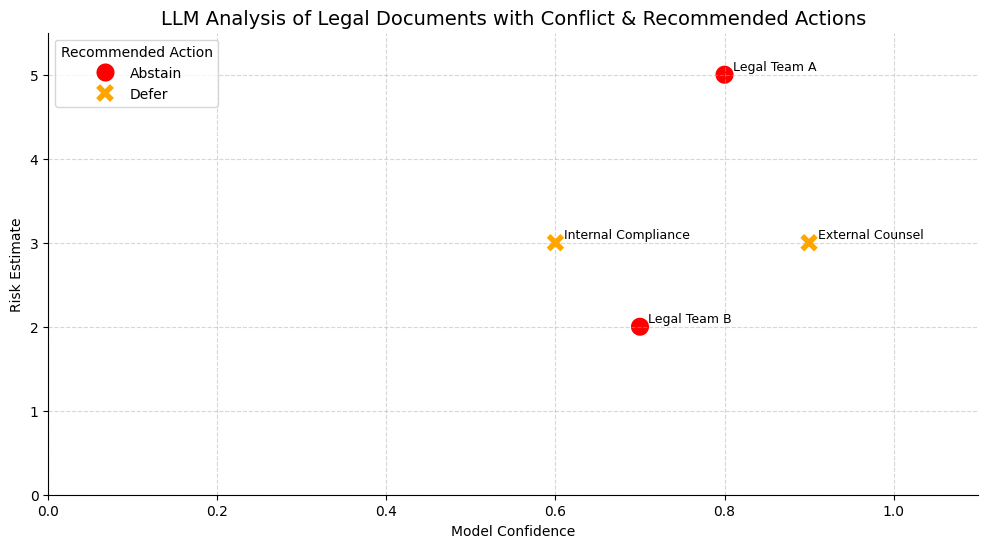

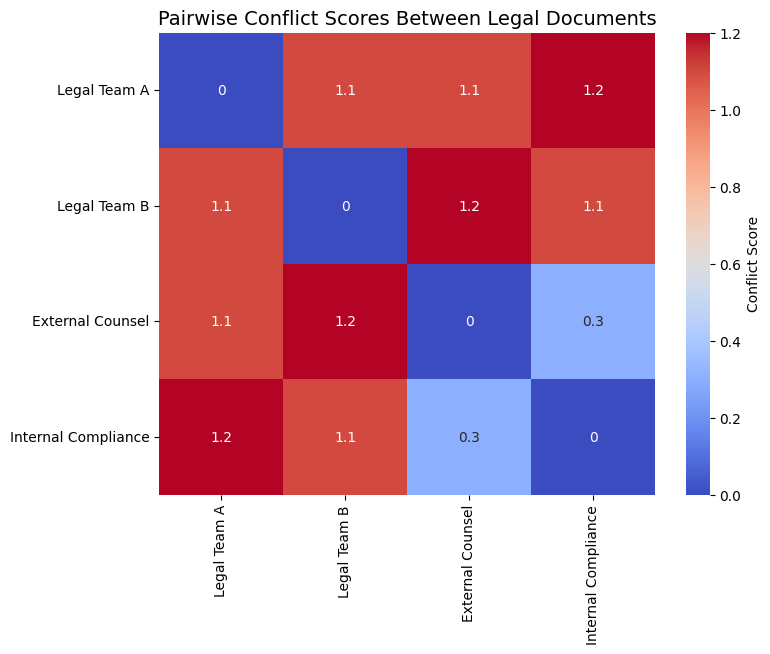

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare DataFrame for visualization
df_docs = pd.DataFrame(legal_action_results)

# Map recommended actions to colors
action_colors = {"Proceed": "green", "Defer": "orange", "Abstain": "red"}
df_docs["color"] = df_docs["recommended_action"].map(action_colors)

plt.figure(figsize=(12, 6))

# Scatter plot: risk estimate vs. model confidence
sns.scatterplot(
    data=df_docs,
    x="model_confidence",
    y="risk_estimate",
    hue="recommended_action",
    palette=action_colors,
    s=200,
    style="recommended_action"
)

# Annotate points with document sources
for i, row in df_docs.iterrows():
    plt.text(
        row["model_confidence"] + 0.01,
        row["risk_estimate"] + 0.05,
        row["source"],
        fontsize=9
    )

plt.title("LLM Analysis of Legal Documents with Conflict & Recommended Actions", fontsize=14)
plt.xlabel("Model Confidence")
plt.ylabel("Risk Estimate")
plt.xlim(0, 1.1)
plt.ylim(0, max(df_docs["risk_estimate"])*1.1)
plt.legend(title="Recommended Action")
plt.grid(True, linestyle="--", alpha=0.5)
sns.despine()

plt.show()

# Optional: visualize conflict matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    document_conflict_matrix,
    annot=True,
    cmap="coolwarm",
    xticklabels=[d["source"] for d in llm_document_analysis],
    yticklabels=[d["source"] for d in llm_document_analysis],
    cbar_kws={"label": "Conflict Score"}
)
plt.title("Pairwise Conflict Scores Between Legal Documents", fontsize=14)
plt.show()

- Creates a **scatter plot** showing risk vs. model confidence for each document, color-coded by recommended action  
- Annotates each document by source for clarity  
- Generates a **heatmap** of pairwise conflict scores to highlight disagreements  
- Provides an **intuitive, visually rich summary** for legal decision-makers  
- Complements numerical analysis with clear operational insights  

At the end of this step, the system’s uncertainty, conflicts, and action recommendations are **immediately interpretable**.

## Step 8 — Summary & Engineering Takeaways

This final step consolidates the findings and highlights the key engineering insights from the ambiguity-aware legal document analysis.  

Goals:  
- Recap system behavior under conflicting or incomplete documents  
- Highlight best practices for abstention, deferral, and human-in-the-loop design  
- Provide guidance for extending or operationalizing the framework

In [8]:
# Summarize key metrics
total_documents = len(documents)
documents_proceed = sum(1 for d in legal_action_results if d["recommended_action"] == "Proceed")
documents_defer = sum(1 for d in legal_action_results if d["recommended_action"] == "Defer")
documents_abstain = sum(1 for d in legal_action_results if d["recommended_action"] == "Abstain")
documents_human_alert = len(legal_human_alerts)

legal_summary_metrics = {
    "Total Documents": total_documents,
    "Proceed": documents_proceed,
    "Defer": documents_defer,
    "Abstain": documents_abstain,
    "Human Alerts": documents_human_alert
}

legal_summary_metrics

{'Total Documents': 4,
 'Proceed': 0,
 'Defer': 2,
 'Abstain': 2,
 'Human Alerts': 4}

- Provides a concise numerical summary of all documents and their recommended actions  
- Highlights how many documents required human review, were deferred, or were safe to proceed  
- Reinforces the importance of **abstention and deferral** in ambiguous legal contexts  
- Serves as a **reference for engineering best practices** in operational LLM systems  

At the end of this step, decision-making under document ambiguity is **transparent, quantifiable, and auditable**, completing the notebook’s objective.